# Kinetic proofreading in templated replication

We implement the simplest model of proofreading and stalling that predicts a counterintuitive ``more accurate is faster'' trade-off.

#### Importing modules

In [1]:
%load_ext autoreload
%autoreload
import numpy as np
from numpy.linalg import inv
from numpy.linalg import pinv
from numpy.linalg import eig
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
import palettable as pal
import itertools
import random

import copy
from tqdm import tqdm
from matplotlib.ticker import LogLocator
from matplotlib.ticker import ScalarFormatter
from scipy import linalg as LA

In [2]:
import seaborn as sns
%matplotlib inline
sns.set_context("talk",rc={"font.size":16,"axes.titlesize":16,"axes.labelsize":24})
sns.set_style("whitegrid",{"grid.color": '.9', 'grid.linestyle': '--','axes.edgecolor': '.6', \
                           'xtick.bottom': True,'ytick.left': True})

In [3]:
from physics import *
from network import *
from tools import save_vars

## Model of kinetic proofreading:  definitions

In [4]:
def gamma_rev(gamma, alpha, phi, j):
    
    return np.exp(-phi) * ( gamma / ( alpha**(j) ) )

def build_k_kp(N, gamma, k_f, k_b, alpha, phi):
    k = np.zeros([N,N])
    ii = range(0, N)
    jj = range(0, N)
    
    for i, j in itertools.product(ii, jj):
        if i!=j:
            if (i==0)*(j<N)*(j>1):
                k[i][j] = gamma
                
            if (j==0)*(i<N)*(i>1):
                k[i][j] = gamma_rev(gamma, alpha, phi, i)

            if (j==i-1)*(i>j):
                k[i][j] = k_f
            
            if (j==i+1)*(j>i):
                k[i][j] = k_b
                
    k[0][1] = gamma + k_b
    k[1][0] = gamma_rev(gamma, alpha, phi, 1) + k_f

    k = normalise_outflow(k, N)
    return k


def build_kw_kp(N, gamma, k_f, k_b, alpha, phi, delta):
    k = np.zeros([N,N])
    ii = range(0, N)
    jj = range(0, N)
    
    for i, j in itertools.product(ii, jj):
        if i!=j:
            if (i==0)*(j<N)*(j>1):
                k[i][j] = gamma*np.exp(j*delta/(N-1))
                
            if (j==0)*(i<N)*(i>1):
                k[i][j] = gamma_rev(gamma, alpha, phi, i)

            if (j==i-1)*(i>j):
                k[i][j] = k_f
                
            
            if (j==i+1)*(j>i):
                k[i][j] = k_b * np.exp(delta/(N-1))
            
                
    k[0][1] = gamma*np.exp(delta/(N-1)) + k_b * np.exp(delta/(N-1))
    k[1][0] = gamma_rev(gamma, alpha, phi, 1) + k_f

    k = normalise_outflow(k, N)
    return k

To maintain detailed balance, see Supplementary Text Sec. 1.1.3, we need to fix the ratio of a (here alpha) and gamma to maintain detailed balance, hence why the two are varied together in the following simulation. If only one was varied, then detailed balance could not be maintained. The different curves shown are for the different values of the driving force, phi.

In [5]:
def buildTradeoff(delta, N, N_max, phi_list):
    err_dkpN, delta_dkpN, fluxN, flux_rN = [ [] for i in range(4)]
    
    for N in range(N, N_max):
        for kk in range(len(phi_list)):
            err_dkp, delta_dkp, flux, flux_r = [ [] for i in range(4)]
    
            # Set initial values of rates
            k_f = 1
            alpha = 1e-2
            k_b = alpha * k_f
            gamma = 0
            phi = phi_list[kk]
            # Definition of the initial state
            init = 0
            # Definition of the final state
            end = N-1
            for dd in range(10000):
                k_b = alpha * k_f
                
                k_r1 = build_k_kp(N, gamma, k_f, k_b, alpha, phi)
                k_r = copy.copy(k_r1)/max_k(copy.copy(k_r1))
    
                k_w = build_kw_kp(N, gamma, k_f, k_b, alpha, phi, delta)
                k_w = copy.copy(k_w)/max_k(copy.copy(k_r1))
    
                err, pr, pw = error_ss(k_r, k_w, N, init, end)
                err_dkp.append( abs(pw)/abs(pr) )
                delta_dkp.append(gamma)
    
                flux.append( abs(pr)+abs(pw) )
                flux_r.append( abs(pr) )
                
                gamma += 0.01
                alpha += 0.001
            err_dkpN.append(err_dkp)
            delta_dkpN.append(delta_dkp)
            fluxN.append(flux)
            flux_rN.append(flux_r)

    return flux_rN, fluxN, err_dkpN

### Building the trade-off plots

In [9]:
delta = 4
# For N=2
phi_list_2 = [0]
# For N=4
phi_list_4 = [0, 1, 2, 3, 4, 5, 5.5, 6, 6.5, 7, 7.5, 8, 8.5, 9, 9.5, 10, 10.5, 11, 12, 15, 20, 30, 50]
# For N=6
phi_list_6 = [0, 1, 2, 3, 4, 5, 5.5, 6, 8, 9, 10, 10.5, 11, 11.5, 12, 13, 14, 15, 16, 17, 18, 19, 20, 30, 50]


yRN2, yN2, xN2 = buildTradeoff(delta, 2,  3, phi_list_2)
yRN3, yN3, xN3 = buildTradeoff(delta, 3, 4, phi_list_4)
yRN4, yN4, xN4 = buildTradeoff(delta, 4, 5, phi_list_4)
yRN6, yN6, xN6 = buildTradeoff(delta, 6, 7, phi_list_6)

### Reversible vs irreversible error correction: irreversible is better at same error rate

['0', '13', '15', '17', '19', '50']


/tmp/ipykernel_84405/2440104134.py:18: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(x, y, 150)
/tmp/ipykernel_84405/2440104134.py:32: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(x, y, 150)
/tmp/ipykernel_84405/2440104134.py:18: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(x, y, 150)
/tmp/ipykernel_84405/2440104134.py:32: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(x, y, 150)
/tmp/ipykernel_84405/2440104134.py:18: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(x, y, 150)
/Users/ravasio/Library/Python/3.11/lib/python/site-packages/numpy/_core/_methods.py:52: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/tmp/ipykernel_84405/2440104134.py:32: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(x, y, 150)


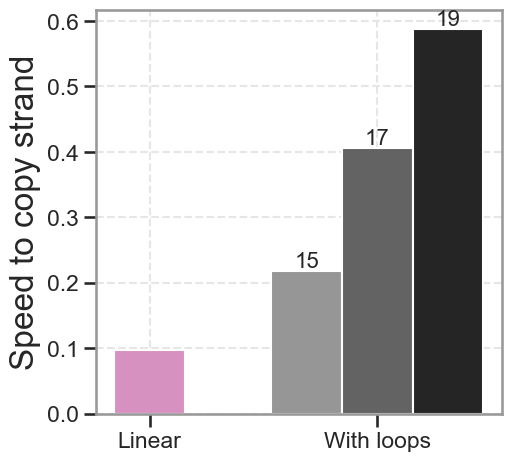

In [10]:
phi_list = [0, 1, 2, 3, 4, 5, 5.5, 6, 8, 9, 10, 10.5, 11, 11.5, 12, 13, 14, 15, 16, 17, 18, 19, 20, 30, 50]
list_phi = [0, 15, 17, 19, 21, len(phi_list)-1]
l = [f"{phi_list[i]}" for i in list_phi]
print(l)

tstall = 5

fig, ax = plt.subplots(figsize=(5, 4.5), layout='constrained')
width = 0.45  # the width of the bars
multiplier = 0
xx = 1  # the label locations
for idx in range(2,5):

    # Reversible error correction: no loop
    x = np.log(np.asarray(xN2[0]))
    y = np.log(1/np.asarray(np.asarray(yRN2[0])) + tstall*np.asarray(xN2[0]))

    z = np.polyfit(x, y, 150)
    f = np.poly1d(z)
    x_new = np.linspace(x[0], x[-1], 10000)
    y_new = f(x_new)

    idx2 = np.where(np.logical_and(np.asarray(x_new)>=-delta+1e-1, np.asarray(x_new)<=-delta+1.01e-1))
    offset = width * multiplier
    rects = ax.bar(0, 1/np.exp(y_new[idx2[0][0]]), width, \
                   color = pal.cartocolors.diverging.Tropic_7.mpl_colors[5])

    # Irreversible error correction: loops
    x = np.log(np.asarray(xN6[list_phi[idx]]))
    y = np.log(1/np.asarray(np.asarray(yRN6[list_phi[idx]])) + tstall*np.asarray(xN6[list_phi[idx]]))

    z = np.polyfit(x, y, 150)
    f = np.poly1d(z)
    x_new = np.linspace(x[0], x[-1], 10000)
    y_new = f(x_new)

    idx6 = np.where(np.logical_and(np.asarray(x_new)>=-delta+1e-1, np.asarray(x_new)<=-delta+1.01e-1))
    offset = width * multiplier
    rects = ax.bar(xx + offset, 1/np.exp(y_new[idx6[0][0]]), width, \
                   color=pal.colorbrewer.sequential.Greys_6.mpl_colors[idx+1])
    
    rect = rects[0]
    ax.text(
            rect.get_x() + rect.get_width() / 2, rect.get_height() , l[idx], ha="center", va="bottom"
        )
        
    multiplier += 1    

ax.set_ylabel('Speed to copy strand')
xlabels = ('Linear', 'With loops')
x = np.arange(len(xlabels))
ax.set_xticks([0,1.45], xlabels)
#ax.set_ylim([0, 0.67])

#plt.savefig('dissipation_barplot.pdf')
#ax.set_yscale('log')
#plt.plot(x,y,'o', x_new, y_new)

### Trade-off curves

7.628827591138688 0.0006019013874678546


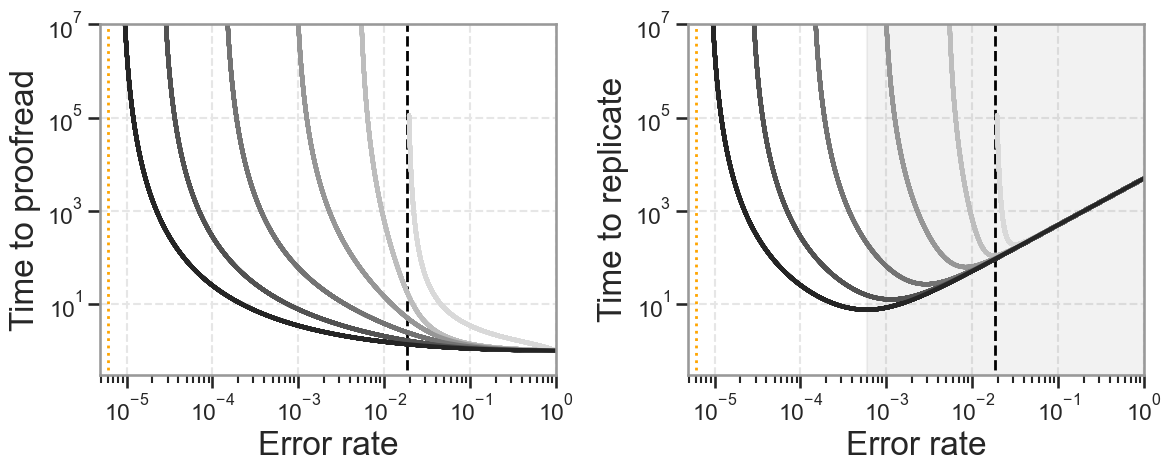

In [11]:
phi_list = [0, 1, 2, 3, 4, 5, 5.5, 6, 8, 9, 10, 10.5, 11, 11.5, 12, 13, 14, 15, 16, 17, 18, 19, 20, 30, 50]
list_phi = [0, 15, 17, 19, 21, len(phi_list)-1]


phi_list_2 = [0, 1, 2, 3, 4, 5, 5.5, 6, 6.5, 7, 7.5, 8, 8.5, 9, 9.5, 10, 10.5, 11, 12, 15, 20, 30, 50]
list_phi_2 = [0, 15, 17, 19, 21, len(phi_list_2)-1]
np.asarray(phi_list)[list_phi]

phi_list_2 = [0]
list_phi_2 = [0]
np.asarray(phi_list)[list_phi]

N_list = [6]

t_stall = 5e3

last = len(list_phi)-1
x = np.asarray(xN6[list_phi[last]])
y = 1/np.asarray(np.asarray(yRN6[list_phi[last]]))+t_stall*np.asarray(xN6[list_phi[last]])
idx_min = np.where(y == y.min())
print(y[idx_min][0], x[idx_min][0])

fig, ax = plt.subplots(1,2, figsize=(12, 5))
for i in range(np.asarray(xN6).shape[0]):
    for j in range(len(list_phi)):

        # Plot the values for N=6 (irreversible error correction with loops)
        ax[1].plot(xN6[list_phi[j]], 1/np.asarray(np.asarray(yRN6[list_phi[j]]))+t_stall*np.asarray(xN6[list_phi[j]]), '-',  \
                   color=pal.colorbrewer.sequential.Greys_7.mpl_colors[j+1], linewidth=3, \
                   label=r'$N=6:$ $\Delta\phi=%d$'%phi_list[list_phi[j]])
        ax[0].plot(xN6[list_phi[j]], 1/np.asarray(np.asarray(yRN6[list_phi[j]])), '-',  \
                   color=pal.colorbrewer.sequential.Greys_7.mpl_colors[j+1], linewidth=3, \
                   label=r'$N=6:$ $\Delta\phi=%d$'%phi_list[list_phi[j]])
                
    if i == 0:
        # Plot limits of error correction given \Delta
        ylim = ax[0].get_ylim()
        ax[0].plot([10**np.log10(np.exp(-delta)), 10**np.log10(np.exp(-delta))], [-5,1e10], '--', color = 'black', \
                   linewidth=2, alpha=1, label=r'$e^{-\Delta}$')
        ax[1].plot([10**np.log10(np.exp(-delta)), 10**np.log10(np.exp(-delta))], [-5,1e10], '--', color = 'black', \
                   linewidth=2, alpha=1, label=r'$e^{-\Delta}$')
        ax[0].plot([10**np.log10(np.exp(-3*delta)), 10**np.log10(np.exp(-3*delta))], [-5,1e10], ':', color = 'orange', \
                   linewidth=2, alpha=1, label=r'$e^{-3\Delta}$')
        ax[1].plot([10**np.log10(np.exp(-3*delta)), 10**np.log10(np.exp(-3*delta))], [-5,1e10], ':', color = 'orange', \
                   linewidth=2, alpha=1, label=r'$e^{-3\Delta}$')
        

ax[1].axvspan(x[idx_min][0], 1, alpha=0.1, color='grey')

ax[0].set_ylim([3e-1,1e7])
ax[1].set_ylim([3e-1,1e7])
ax[0].set_xlim([0.8*10**np.log10(np.exp(-3*delta)),1e0])
ax[1].set_xlim([0.8*10**np.log10(np.exp(-3*delta)),1e0])
ax[0].set_ylabel(r'Time to proofread')
ax[0].set_xlabel(r'Error rate')
ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[1].set_ylabel(r'Time to replicate')
ax[1].set_xlabel(r'Error rate')
ax[1].set_yscale('log')
ax[1].set_xscale('log')
#leg = plt.legend(bbox_to_anchor=(1, 1), frameon=False)
plt.tight_layout()
#plt.savefig('dkp_tradeoff_mu.pdf')
plt.show()

### Derivative of time with no stalling with respect to error rate

In [12]:
def compute_derivative(x,y):
    
    d = []
    dy = y[1]-y[0]
    dx = x[1]-x[0]
    if dx == 0:
        dx = 1
    d.append( dy/dx )
    for i in range(len(x)-1):
        dy = y[i+1]-y[i]
        dx = x[i+1]-x[i]
        if dx == 0:
            dx = 1
        d.append( dy/dx )
        
    return np.asarray(d)

Text(0, 0.5, 'd$t$/d$\\mu$')

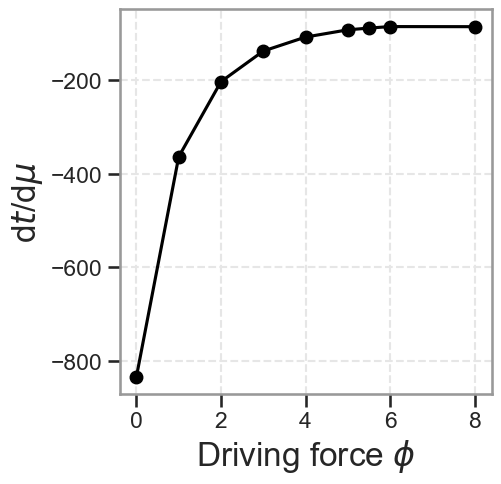

In [18]:
dtdu = [] 
list_phi = [0, 1,2,3,4,5,6,7, 8]
th = [[0.02,0.0202], [0.04, 0.041]]

for t in th:
    for j in range(len(list_phi)):
        xx = xN6[list_phi[j]]
        #yy = 1/np.asarray(np.asarray(yN6[list_phi[j]]))+t_stall*np.asarray(xN6[list_phi[j]])
        yy = 1/np.asarray(np.asarray(yRN6[list_phi[j]]))
        th_mul = t[0]
        th_muh = t[1]
        #th_mul = np.exp(-delta)
        #th_muh = 0.7e-1
        list_mu = np.where(np.logical_and(np.asarray(xx)>=th_mul, np.asarray(xx)<=th_muh))[0]

        n = list_mu[0]  
        dtdu.append(compute_derivative([xx[n], xx[n+1]], [yy[n], yy[n+1]])[0])
            
fig, ax = plt.subplots(1, 1, figsize=(4.8, 5))
phi = [phi_list[list_phi[j]] for j in range(len(list_phi))]
#ax.plot(phi, dtdu[0:len(list_phi)], '-ok')
ax.plot(phi, dtdu[len(list_phi):2*len(list_phi)], '-ko')
ax.set_xlabel(r'Driving force $\phi$')
ax.set_ylabel(r'd$t$/d$\mu$')
#plt.savefig('derivative_dissipation.pdf')

## Identify and plot crossover error rate values as function of driving force and N

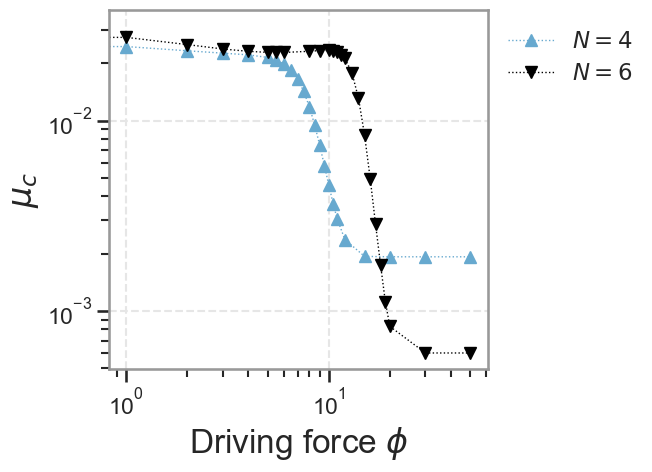

In [14]:
t_stall = 5e3
mu_cN4 = []
for i in range(np.asarray(xN4).shape[0]):
    tmp = 1/np.asarray(np.asarray(yRN4[i]))+t_stall*np.asarray(xN4[i])
    idx = np.where(tmp == tmp.min())[0][0]
    mu_cN4.append( xN4[i][idx] )
    
mu_cN6 = []
for i in range(np.asarray(xN6).shape[0]):
    tmp = 1/np.asarray(np.asarray(yRN6[i]))+t_stall*np.asarray(xN6[i])
    idx = np.where(tmp == tmp.min())[0][0]
    mu_cN6.append( xN6[i][idx] )
    
fig, ax1 = plt.subplots(1,1, figsize=(6.8, 5), sharey=True)

phi_list4 = [0, 1, 2, 3, 4, 5, 5.5, 6, 6.5, 7, 7.5, 8, 8.5, 9, 9.5, 10, 10.5, 11, 12, 15, 20, 30, 50]
phi_list6 = [0, 1, 2, 3, 4, 5, 5.5, 6, 8, 9, 10, 10.5, 11, 11.5, 12, 13, 14, 15, 16, 17, 18, 19, 20, 30, 50]
ax1.plot(phi_list4, mu_cN4, ':^', markersize=8, linewidth=1, color=pal.colorbrewer.sequential.PuBuGn_4.mpl_colors[2], label=r'$N=4$')
ax1.plot(phi_list6, mu_cN6, ':v', markersize=8, linewidth=1, color='black', label=r'$N=6$')


ax1.set_ylabel(r'$\mu_c$')
ax1.set_xlabel(r'Driving force $\phi$')
ax1.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
ax1.set_yscale('log')
ax1.set_xscale('log')
plt.tight_layout()
#plt.savefig('muc_phi.pdf')

In [15]:
phi_list = [0]
yR0, y0, x0 = buildTradeoff(delta, 2,  12, phi_list)
phi_list = [50]
yR50, y50, x50 = buildTradeoff(delta, 2,  12, phi_list)

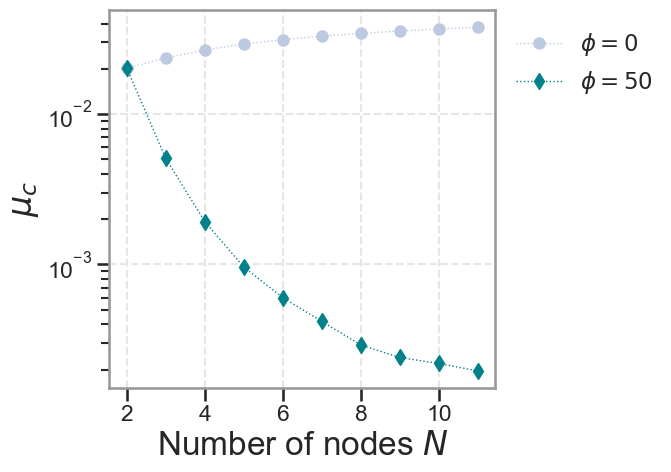

In [16]:
N_max = 12
t_stall = 5e3
mu_c0 = []
for i in range(np.asarray(x0).shape[0]):
    tmp = 1/np.asarray(np.asarray(y0[i]))+t_stall*np.asarray(x0[i])
    idx = np.where(tmp == tmp.min())[0][0]
    mu_c0.append( x0[i][idx] )
    
mu_c50 = []
for i in range(np.asarray(x50).shape[0]):
    tmp = 1/np.asarray(np.asarray(y50[i]))+t_stall*np.asarray(x50[i])
    idx = np.where(tmp == tmp.min())[0][0]
    mu_c50.append( x50[i][idx] )
    
fig, ax2 = plt.subplots(1,1, figsize=(7, 5), sharey=True)

ax2.plot(list(range(2, N_max)), mu_c0, ':o', markersize=8, linewidth=1, \
         color=pal.colorbrewer.sequential.PuBuGn_4.mpl_colors[1], label = r'$\phi=0$')
ax2.plot(list(range(2, N_max)), mu_c50, ':d', markersize=8, linewidth=1, \
         color=pal.colorbrewer.sequential.PuBuGn_4.mpl_colors[3], label = r'$\phi=50$')

ax2.set_ylabel(r'$\mu_c$')
ax2.set_xlabel(r'Number of nodes $N$')
#ax2.set_ylim([2e-3,1.2e-1])
ax2.legend(bbox_to_anchor=(1, 1), frameon=False)
ax2.set_yscale('log')
plt.tight_layout()
#plt.savefig('muc_N.pdf')

### Plot the trade-off curve for different values of the stalling time

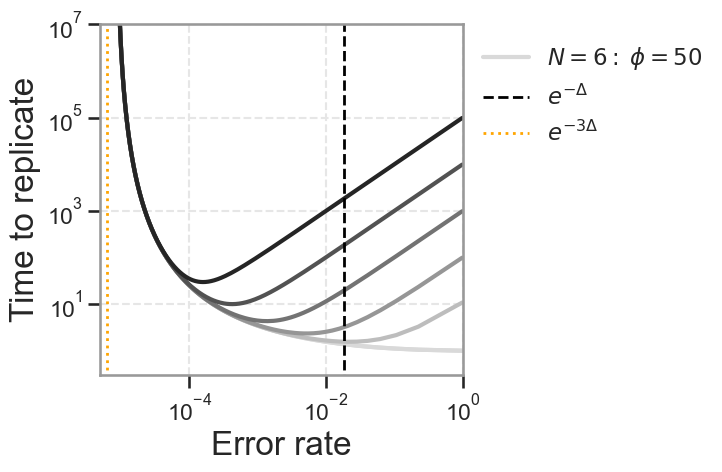

In [19]:
list_phi = [len(phi_list)-1]
phi_list = [0, 1, 2, 3, 4, 5, 5.5, 6, 8, 9, 10, 10.5, 11, 11.5, 12, 13, 14, 15, 16, 17, 18, 19, 20, 30, 50]
np.asarray(phi_list)[list_phi]

N_list = [6]

t_stall = [0, 1e1, 1e2, 1e3, 1e4, 1e5]

fig, ax = plt.subplots(1,1, figsize=(7.5, 5), sharey=True)
for j in range(len(list_phi)):
    for k in range(len(t_stall)):
        if k==0:
            ax.plot(xN6[list_phi[j]], 1/np.asarray(np.asarray(yRN6[list_phi[j]]))+t_stall[k]*np.asarray(xN6[list_phi[j]]), '-',  \
                   color=pal.colorbrewer.sequential.Greys_7.mpl_colors[k+1], linewidth=3, \
                   label=r'$N=6:$ $\phi=%d$'%phi_list[list_phi[j]])
            
        ax.plot(xN6[list_phi[j]], 1/np.asarray(np.asarray(yRN6[list_phi[j]]))+t_stall[k]*np.asarray(xN6[list_phi[j]]), '-',  \
                   color=pal.colorbrewer.sequential.Greys_7.mpl_colors[k+1], linewidth=3)
            
    ylim = ax.get_ylim()
    ax.plot([10**np.log10(np.exp(-delta)), 10**np.log10(np.exp(-delta))], [-5,1e10], '--', color = 'black', \
               linewidth=2, alpha=1, label=r'$e^{-\Delta}$')
    ax.plot([10**np.log10(np.exp(-3*delta)), 10**np.log10(np.exp(-3*delta))], [-5,1e10], ':', color = 'orange', \
               linewidth=2, alpha=1, label=r'$e^{-3\Delta}$')
        
ax.set_ylim([3e-1,1e7])
ax.set_xlim([0.8*10**np.log10(np.exp(-3*delta)),1e0])
ax.set_ylabel(r'Time to replicate')
ax.set_xlabel(r'Error rate')
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(bbox_to_anchor=(1, 1), frameon=False)
plt.tight_layout()
#plt.savefig('dkp_tradeoff_varyingstall.pdf')
plt.show()